## Autoencoder Convolucional SSA - Two layers HH

Continuamos el estudio de la aproximación SSA a primer orden. Entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz en el canal HH - $\sigma_{HH}(\hat{k}_x, \hat{k}_y)$ -, generados por un modelo de dos capas rugosas bajo la aproximación SSA. 

### Generamos los datos


Usamos un modelo numérico para generar nuestros datos. 

In [37]:
import numpy as np

import two_rough_layers 

# Parámetros fijos
realizations = 20480

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*np.pi/.245
d = np.linspace(.1, .7, 35)
ep1, ep2 = np.arange(3, 38), np.arange(3, 38)
s1, s2 = np.linspace(.004, .012, 35), np.linspace(.004, .012, 35)
l1, l2 = 6*s1, 6*s2
theta_i, phi_i = 38.5*np.pi/180, 0 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))


for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(35, size=7)
    
    # Armo una tupla con los argumentos de S01     
    args = (k0, THETA, PHI,
            theta_i, phi_i, 
            ep1[index[0]], ep2[index[1]],
            s1[index[2]], l1[index[3]],
            s2[index[4]], l2[index[3]],
            d[index[6]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = two_rough_layers.suma_O1(*args)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh #+ np.abs(rng.normal(0, .03*np.std(s_hh), size=PHI.shape))

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        sigma[i, :, :] = s_hh_noise
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')

# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (20480, 64, 64)


Guardamos los datos para re-usarlos más adelante

In [38]:
import os 

# Get data directory path
src_dir = os.path.normpath(os.getcwd() + '/../..')
data_dir = os.path.join(src_dir, 'data/ssa')

# Save Sigma in file
file_name = 'scatt_cross_section.npy'

In [39]:
np.save(os.path.join(data_dir, file_name), sigma)

### Preparamos los datos

Comencemos separando los datos en conjuntos de entrenamiento y testeo. Apliquemos una estandarización de los datos, teniendo en cuenta el IQR.

In [2]:
# Cargamos los datos
import numpy as np
sigma = np.load(os.path.join(data_dir, file_name))

In [40]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.2)

print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (16384, 64, 64)
Tamaño de los datos de testeo: (4096, 64, 64)


Defino una clase que realiza el scaleo, así pueod usarla más adelante en un pipeline.

In [41]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(RobustScaler):
    def __init__(self):
        super().__init__()

    def fit(self, X):
        return super().fit(X.reshape(-1, X.shape[-1]), y=None)
    
    def transform(self, X):
        X_shape = X.shape
        scaled = super().transform(X.reshape(-1, X_shape[-1]))
        return scaled.reshape(X_shape)

    def fit_transform(self, X, **fit_params):
        X_shape = X.shape
        transformed = super().fit_transform(X.reshape(-1, X_shape[-1]), y=None, **fit_params) 
        return transformed.reshape(X_shape)      

In [42]:
# Fiteo con el conjunto de entrenamiento
scaler = Scaler().fit(sigma_train)

# Transformo ambos conjuntos
scaled_train = scaler.transform(sigma_train)
scaled_test = scaler.transform(sigma_test)

In [43]:
scaled_train, scaled_test = np.expand_dims(scaled_train, axis=-1), np.expand_dims(scaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {scaled_train.shape}')
print(f'Tamaño de los datos de testeo: {scaled_test.shape}')

Tamaño de los datos de entrenamiento: (16384, 64, 64, 1)
Tamaño de los datos de testeo: (4096, 64, 64, 1)


#### Visualizo las soluciones generadas

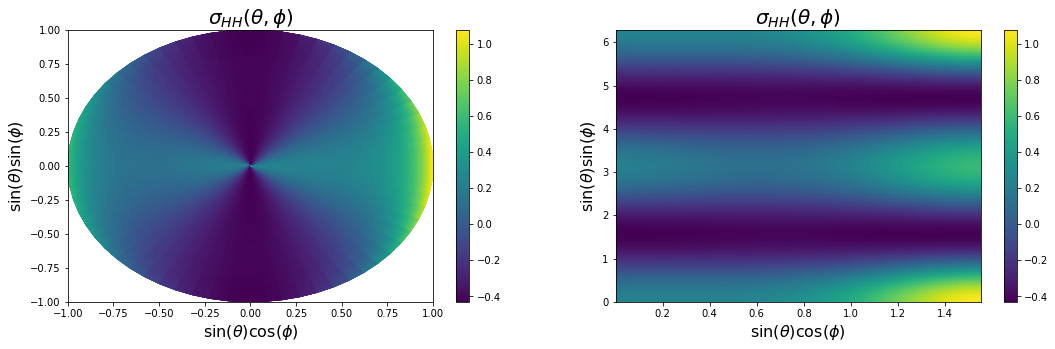

In [44]:
from matplotlib import pyplot as plt

# Elijo una imagen al azar
rng = np.random.default_rng()
index = rng.integers(scaled_train.shape[0]) 
img = scaled_train[index, :, :, 0]

# Dominios 
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(18, 5))

# Canal HH
ax = plt.subplot(1, 2, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 2, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud')
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


### Definimos el modelo de aprendizaje profundo: Autoencoder Convolucional

Defino un modelo que voy a ir retocando para llegar a que *pueda aprender* los datos generados. Una vez que consiga esto, pasamos a ajustar hyperparámetros.

In [45]:
import tensorflow as tf

# Config tf verbosesity 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Check GPU's 
tf.config.list_physical_devices('GPU')

[]

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim, kernel_init='glorot_uniform'):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (64, 64, 1)), 
                                            layers.Conv2D(4, (6, 6), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(16, (5, 5), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(32, (4, 4), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Conv2D(32, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Flatten(),
                                            
                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #layers.Dropout(.2),

                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),                                          

                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Reshape(target_shape=(6,6,32)),
                                            
                                            layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(32, (4, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(16, (5, 5), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(4, (6, 6), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="linear", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

    # def fit(self, X, **kwargs):
    #     return super().fit(X, X, **kwargs)    

In [115]:
tf.keras.backend.clear_session()
del autoencoder

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [47]:
autoencoder = ConvAutoencoder(12, kernel_init='normal')
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 59, 59, 4)         148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9

In [57]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                832       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1152)              296064    
                                                                 
 dropout_3 (Dropout)         (None, 1152)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)         

### Entrenamos nuestro Conv-Autoencoder

Defino Callbacks para reducir el learning rate y cortar el entrenamiento si no mejora.

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.15,
    patience=50,
    verbose=0,
    mode="min",
    min_delta=0.3,
    cooldown=0,
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor='loss', 
    patience=75, 
    mode='min', 
    min_delta=0.1,
    restore_best_weights=True
    )

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

Generemos un optimizador con decay rate

2022-08-19 16:51:32.292120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


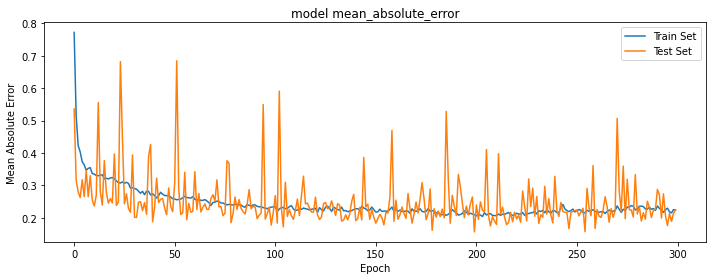

In [49]:
opt=tf.keras.optimizers.RMSprop(learning_rate=0.0003)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder.fit(
    scaled_train, 
    scaled_train,
    epochs = 300,
    batch_size = 32,
    verbose = 0,
    validation_data=(scaled_test, scaled_test),
    #callbacks=[reduce_lr]
    )

# Visualizo el entrenamiento
plt.figure(figsize = (10, 4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()


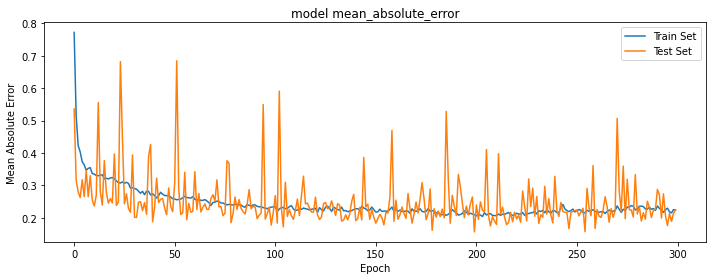

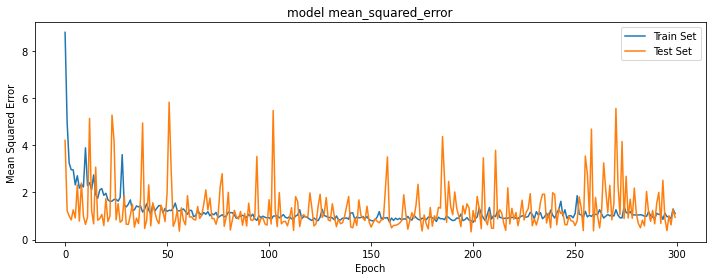

In [50]:
from matplotlib import pyplot as plt
# Visualizo el loss function
plt.figure(figsize = (10, 4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()

# Visualizo el metrica
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

In [29]:
print(np.mean(history.history['mean_squared_error'][:200])-np.mean(history.history['mean_squared_error'][:150]))
print(history.history['mean_squared_error'][290])

-0.2626762648920218
0.355026513338089


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_3_ssa_two_layer_HH.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

#### Visualizamos los resultados

Veamos cómo son las imágenes generadas por nuestro modelo

In [53]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(scaled_train[:1000]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

<Figure size 1296x360 with 0 Axes>

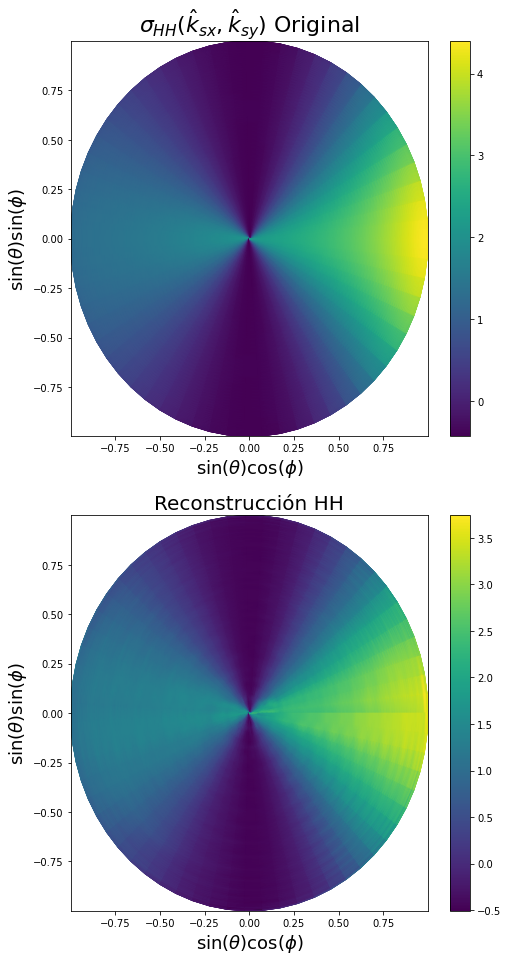

In [60]:
n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(encoded_imgs.shape[0])

# Dominios 
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(18, 5))

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = scaled_train[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


### Ajuste de hyperparámetros

Vamos a buscar el optimizador, learning rate, inicializador de pesos y batch size optimos de nuestro modelo. Para eso vamos a usar Cross Validation junto con Grid Seach. Usamos GridSearchCV de Sklearn, junto con un wrapper de keras para nuestor modelo: KerasRegresor

In [17]:
from tensorflow.keras import optimizers as opt
from tensorflow.keras.losses import MeanSquaredError

from keras.wrappers.scikit_learn import KerasRegressor

def create_autoencoder(optimizer='adam',
                       learning_rate=0.0001,
                       beta_momentum=.9,
                       init='glorot_uniform'):
    tf.random.set_seed(123)                   

    # Create optimazer
    select_optimizer = {
        'adam': opt.Adam(learning_rate=learning_rate, beta_1=beta_momentum),
        'RMSProp': opt.RMSprop(learning_rate=learning_rate),
        'sgd': opt.SGD(learning_rate=learning_rate)
                        }
    gradient_descent = select_optimizer.get(optimizer, 'adam')

    # Create and Compile Model
    model = ConvAutoencoder(12, kernel_init=init)
    model.compile(
        optimizer=gradient_descent,
        loss=MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
        )

    return model

Genero un wrap para usar objetos de keras en scikitlearn

In [96]:
sckit_model = KerasRegressor(
    create_autoencoder, 
    verbose=0, 
    epochs=100, 
    #callbacks=[early_stopping]
    )

Genero un pipeline con la estandarización utilizada y el modelo de keras

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pipeline = Pipeline(steps=[
    ('scaler' , Scaler()),
    ('add_xis', FunctionTransformer(np.expand_dims, kw_args={'axis':-1})),
    ('model', sckit_model)
    ])

Hacemos un Cross Validation sampleando aleatoriamente en la grilla de hyperpárametros.

In [92]:
from sklearn.model_selection import RandomizedSearchCV

l_rate = [0.00005, 0.0001, 0.0005, 0.001, 0.003]
kernel_init = ['glorot_uniform', 'lecun_uniform', 'normal']
batch = [32, 64, 256, 512, 1024]
grad_optimizer = ['adam', 'RMSProp', 'sgd']

hyperparam_grid = {'model__optimizer': grad_optimizer,
                   'model__learning_rate': l_rate,
                   'model__init': kernel_init,
                   'model__batch_size': batch}

cv = RandomizedSearchCV(pipeline, 
                        hyperparam_grid,
                        cv=5, 
                        n_iter=25, 
                        random_state=1, 
                        verbose=0,
                        scoring='neg_mean_squared_error' 
                        )


Fiteamos el modelo para cada hyperparametro sampleado. Para eso armamos un Pipeline en donde estandarizamos los datos y fiteamos para cada train set dentro del kfold. 

In [ ]:
tuned_model = cv.fit(sigma_train[:30], sigma_train[:30])

In [ ]:
# print results
print(f'Best Score for {tuned_model.best_score_:.4} using {tuned_model.best_params_}')
means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Score for -353.1 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-353.1, std=89.91 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-369.1, std=94.38 using {'optimizer': 'RMSProp', 'learning_rate': 5e-05, 'init': 'normal', 'batch_size': 512}
mean=-365.9, std=92.66 using {'optimizer': 'adam', 'learning_rate': 0.0001, 'init': 'glorot_uniform', 'batch_size': 256}
mean=-369.0, std=94.39 using {'optimizer': 'sgd', 'learning_rate': 5e-05, 'init': 'lecun_uniform', 'batch_size': 64}


Lamentablemente no podemos usar un pipeline para hacer nuestro cv. Hay conflictos con que en nuestro caso X=sigma e y=sigma. Solo se scalea X -además agrega un eje-, mientras que y queda igual. Además, el fit de keras regresor también nos limita con la cantidad de axis de y.

#### Randomized Search

Hagamos cv "a mano" con KFold, de paso podemos estar seguro que luego de cada iteración se sobreescribe el modelo haciendo un keras.backend.clear_session().

In [10]:
from sklearn.model_selection import KFold
from itertools import islice, product
import random

# Hyperparameter Space
l_rate = [0.00005, 0.0001, 0.0005, 0.001, 0.003]
kernel_init = ['glorot_uniform', 'lecun_uniform', 'normal']
batch = [32, 64, 256, 512, 1024]
grad_optimizer = ['adam', 'RMSProp', 'sgd']

space_grid = {
    'optimizer': grad_optimizer,
    'learning_rate': l_rate,
    'init': kernel_init,
    'batch_size': batch
                   }
# N samples for randomized search                   
n_samples = 30

# Form a list of hyperparameters values
hyperparameters_list = list(space_grid.values())

# Get all posible combinations of parameters
all_combinations = []
for items in product(*hyperparameters_list):
    all_combinations.append(dict(zip(space_grid.keys(), items)))

# Sample n_samples randomly from all combinations
rng = np.random.default_rng(123)
sampled_hyperparams = rng.choice(all_combinations, n_samples)

# Add default configuration
sampled_hyperparams = np.append(
    sampled_hyperparams, 
    {
        'optimizer': 'adam', 
        'learning_rate': 0.0001, 
        'init': 'glorot_uniform', 
        'batch_size': 1024
        }
        )

# Variate all over samples 
configurations_score = []
best_score = 1e4
for params in sampled_hyperparams:

    # K-Fold cross validation with each hyperparam combination
    cv = KFold(n_splits=5)

    # Initialize list to save scores
    fold_score = []

    for train_index, test_index in cv.split(sigma_train[:7000]):
        # Split into train and test
        S_train, S_test = sigma_train[train_index], sigma_train[test_index]
        
        # Scale each set
        scaler = Scaler().fit(S_train)
        scaled_train = scaler.transform(S_train)
        scaled_test = scaler.transform(S_test)

        # Add extra dimension for ConvAE input
        scaled_train = np.expand_dims(scaled_train, axis=-1)
        scaled_test =  np.expand_dims(scaled_test, axis=-1)

        # Generate Model wrapper and compile it
        conv_ae = KerasRegressor(
            create_autoencoder,
            **params,
            nb_epoch=150,
            verbose=0
        )
        history = conv_ae.fit(scaled_train, scaled_train)

        # Calculate score
        score = history.history['mean_squared_error'][-30:]
        fold_score.append(np.mean(score))

        # Clear Tensorflow graph
        tf.keras.backend.clear_session()
        del conv_ae 

    run_data = {'params' : params, 'score': np.mean(fold_score)}
    configurations_score.append(run_data)
        
    if run_data['score'] < best_score:
        best_configuration = run_data          

    print(f'Parameters Configuration: {params}, score: {np.mean(fold_score)}')    

Parameters Configuration: {'optimizer': 'adam', 'learning_rate': 5e-05, 'init': 'glorot_uniform', 'batch_size': 512}, score: 20.177989959716797
Parameters Configuration: {'optimizer': 'sgd', 'learning_rate': 5e-05, 'init': 'glorot_uniform', 'batch_size': 512}, score: 20.178203201293947
Parameters Configuration: {'optimizer': 'RMSProp', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 512}, score: 45.48917465209961
Parameters Configuration: {'optimizer': 'adam', 'learning_rate': 5e-05, 'init': 'normal', 'batch_size': 256}, score: 20.176809310913086
Parameters Configuration: {'optimizer': 'sgd', 'learning_rate': 0.001, 'init': 'lecun_uniform', 'batch_size': 1024}, score: 20.171250534057616
Parameters Configuration: {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'glorot_uniform', 'batch_size': 1024}, score: 20.157307052612303
Parameters Configuration: {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 256}, score: 19.83194770812988
Parameters Confi

Guardamos la configuración optimizada en un json

In [12]:
import json

json_path = os.path.join(data_dir, 'model_configuration_ssa_scs.json')

with open(json_path, 'w') as file_:
    json.dump(best_configuration, file_, indent=4)

Veamos los resultados ordenados por score

In [20]:
import pandas as pd

for config in configurations_score: config['params'].update({'score' : config['score']})

configurations = [config['params'] for config in configurations_score]

scores = pd.DataFrame.from_records(configurations).sort_values(by='score')
scores

,optimizer,learning_rate,init,batch_size,score
21,RMSProp,0.00050,normal,32,11.880505
7,adam,0.00050,normal,64,16.202279
23,adam,0.00100,normal,32,17.287787
12,RMSProp,0.00010,normal,64,18.658353
14,RMSProp,0.00010,normal,64,18.658353
20,adam,0.00005,lecun_uniform,32,18.817432
8,RMSProp,0.00005,glorot_uniform,32,19.032683
22,adam,0.00300,glorot_uniform,32,19.537491
27,adam,0.00100,glorot_uniform,512,19.767834
6,adam,0.00100,normal,256,19.831948


#### GridSearch

Con estos resultados, hacemos un gridsearch fino sobre el learning_rate fijando la inicialización de los pesos en 'normal', tomando solamente dos valores de batch_size={32, 64}, quedandonos con RMSprop y Adam. El intervalo en el que variamos el learning_rate va a ser de 1e-4 a 1e-3.

In [20]:
from sklearn.model_selection import KFold
from itertools import islice, product

# Hyperparameter Space
learning_rate = np.arange(1e-4, 1e-3, 1e-4)
kernel_init = 'normal'
batch = [32, 64]
grad_optimizer = ['adam', 'RMSProp']

# Variate all over hparams space 
configurations_score = []
best_score = 1e4
for l_rate in learning_rate:
    for optimazer in grad_optimizer:
        for batch_size in batch:
            configuration = {
                'optimizer': optimazer, 
                'learning_rate': l_rate, 
                'init': kernel_init, 
                'batch_size': batch_size
            }

            # K-Fold cross validation with each hyperparam combination
            cv = KFold(n_splits=5)

            # Initialize list to save scores
            fold_score = []

            for train_index, test_index in cv.split(sigma_train[:7000]):
                # Split into train and test
                S_train, S_test = sigma_train[train_index], sigma_train[test_index]
                
                # Scale each set
                scaler = Scaler().fit(S_train)
                scaled_train = scaler.transform(S_train)
                scaled_test = scaler.transform(S_test)

                # Add extra dimension for ConvAE input
                scaled_train = np.expand_dims(scaled_train, axis=-1)
                scaled_test =  np.expand_dims(scaled_test, axis=-1)

                # Generate Model wrapper and compile it
                conv_ae = KerasRegressor(
                    create_autoencoder,
                    **configuration,
                    nb_epoch=150,
                    verbose=0
                )
                history = conv_ae.fit(scaled_train, scaled_train)

                # Calculate score
                score = history.history['mean_squared_error'][-30:]
                fold_score.append(np.mean(score))

                # Clear Tensorflow graph
                tf.keras.backend.clear_session()
                del conv_ae 

            configuration.update({'score': np.mean(fold_score)})
            configurations_score.append(configuration)
                
            if configuration['score'] < best_score:
                best_configuration = configuration          


In [22]:
import json
import pandas as pd
# Guardo la mejor configuración y visualizo el ranking
json_path = os.path.join(data_dir, 'model_configuration_ssa_scs.json')

with open(json_path, 'w') as file_:
    json.dump(best_configuration, file_, indent=4)

scores = pd.DataFrame.from_records(configurations_score).sort_values(by='score')
scores

,optimizer,learning_rate,init,batch_size,score
10,RMSProp,0.0003,normal,32,10.192988
14,RMSProp,0.0004,normal,32,10.245154
18,RMSProp,0.0005,normal,32,11.341161
6,RMSProp,0.0002,normal,32,11.653521
22,RMSProp,0.0006,normal,32,11.941248
20,adam,0.0006,normal,32,11.982259
16,adam,0.0005,normal,32,12.096486
26,RMSProp,0.0007,normal,32,12.264033
12,adam,0.0004,normal,32,12.707110
8,adam,0.0003,normal,32,12.747289


#### Selección de learning rate decay

Nos quedamos con las configuraciones que mejor ajustan. Generamos algunas variantes de las mismas variando el learning rate usando keras.optimizers.schedules para asignarle un decaimiento al learning rate.

In [2]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay

# Global parameters
FINAL_LEARNING_RATE = 0.00005
TRAIN_SIZE = 7000

def rmsProp_with_decay(
    initial_value=0.0003, 
    final_value=FINAL_LEARNING_RATE, 
    train_samples=TRAIN_SIZE,
    epochs=300, 
    batch_size=32, 
    decay_type='polynomial',
    centered=False
    ):
    # Set TensorFlow seed for reproducible results
    tf.random.set_seed(123)

    # Continous decay parameters
    decay_rate = (initial_value - final_value)/epochs
    decay_steps = int(train_samples / batch_size) 
    total_steps = decay_steps*epochs
    inverse_decay_steps = (final_value*decay_rate*total_steps / 
                            (initial_value - final_value))
    
    # Piecewise decay parameters
    steps = 6
    step_len = int(total_steps / steps)
    step_decay = (initial_value - final_value) / steps

    schedulers_type = {
        'polynomial' : PolynomialDecay(
            initial_learning_rate=initial_value, 
            decay_steps=total_steps, 
            end_learning_rate=FINAL_LEARNING_RATE, 
            power=3
            ), 
        'step' : PiecewiseConstantDecay(
            boundaries=[bound for bound in range(step_len, total_steps, step_len)],
            values=[value for value in np.arange(initial_value, final_value, -step_decay)]
            ),
        'inverse' : InverseTimeDecay(
            initial_learning_rate=initial_value, 
            decay_steps=inverse_decay_steps, 
            decay_rate=decay_rate,
            ), 
        'exponential' : ExponentialDecay(
            initial_learning_rate=initial_value,
            decay_steps=total_steps,
            decay_rate=final_value/initial_value
            ),
        'constant' : initial_value
        }
    scheduler = schedulers_type.get(decay_type, 'polynomial')

    # Gradient descent optimizer
    opt = tf.keras.optimizers.RMSprop(    
        learning_rate=scheduler,
        rho=0.9,
        momentum=0.0,
        centered=centered,
        name=f'RMSprop_{decay_type}'
        )

    # Create and Compile Model
    model = ConvAutoencoder(12, kernel_init='normal')
    model.compile(
        optimizer=opt,
        loss=MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
        )    
    
    return model


Veamos la pinta del learning rate para cada epoch

Text(0.5, 1.0, 'Learning rate decay during training')

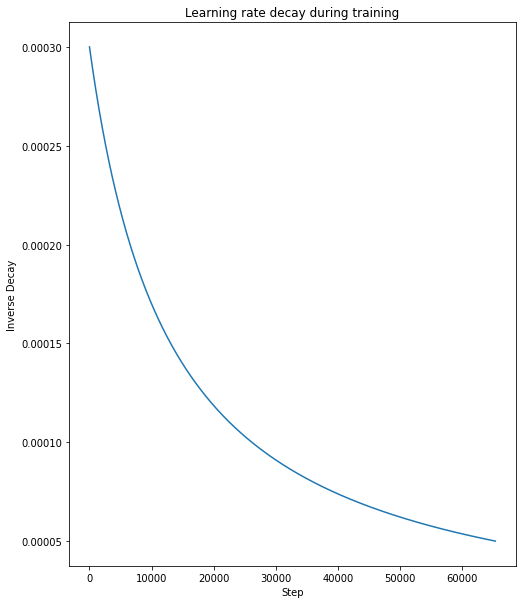

In [35]:
from matplotlib import pyplot as plt
import numpy as np
# Global parameters
FINAL_LEARNING_RATE = 0.00005
TRAIN_SIZE = 7000

# Define size of mini batch and training epochs
epochs = 300
batch_size = 32

# Learning rate decay and steps
initial_value = 0.0003
final_value = FINAL_LEARNING_RATE
train_samples = TRAIN_SIZE

# Continous decay parameters
decay_rate = (initial_value - final_value)/epochs
decay_steps = int(train_samples / batch_size) 
total_steps = decay_steps*epochs
inverse_decay_steps = final_value*decay_rate*total_steps/(initial_value - final_value)


# Piecewise decay parameters
steps = 4
step_len = int(total_steps / steps)
step_decay = (initial_value - final_value) / steps


polynomial_lr = InverseTimeDecay(
            initial_learning_rate=initial_value, 
            decay_steps= inverse_decay_steps, 
            decay_rate=decay_rate,
            )

decay = [polynomial_lr(step) for step in range(1, total_steps + 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.plot(range(1, total_steps + 1), decay)
ax.set_xlabel('Step')
ax.set_ylabel('Inverse Decay')
ax.set_title('Learning rate decay during training')

Hagamos un GridSearch variando el tipo de decay, el valor final del decay y cambiando la opción "centered" de RMSprop.

In [ ]:
from sklearn.model_selection import KFold
from itertools import islice, product

# Hyperparameter Space
schedulers = ['polynomial', 'step', 'inverse', 'exponential', 'constant'], 
initial_values = [0.0003, 0.0004]
final_values = [0.001, 0.00005, 0.00001, 0.000005]
centered = [False, True]

# Variate all over hparams space 
configurations_score = []
best_score = 1e4

for decay_type in schedulers:
    for init_value in initial_values:
        for f_value in final_values:
            for center in centered:
            
                configuration = {
                    'decay_type': decay_type, 
                    'initial_value': init_value, 
                    'final_value': f_value, 
                    'centered': center
                }

                # K-Fold cross validation with each hyperparam combination
                cv = KFold(n_splits=5)

                # Initialize list to save scores
                fold_score = []

                for train_index, test_index in cv.split(sigma_train[:7000]):
                    # Split into train and test
                    S_train, S_test = sigma_train[train_index], sigma_train[test_index]
                    
                    # Scale each set
                    scaler = Scaler().fit(S_train)
                    scaled_train = scaler.transform(S_train)
                    scaled_test = scaler.transform(S_test)

                    # Add extra dimension for ConvAE input
                    scaled_train = np.expand_dims(scaled_train, axis=-1)
                    scaled_test =  np.expand_dims(scaled_test, axis=-1)

                    # Generate Model wrapper and compile it
                    conv_ae = KerasRegressor(
                        create_autoencoder,
                        **configuration,
                        nb_epoch=300,
                        verbose=0
                    )
                    history = conv_ae.fit(scaled_train, scaled_train)

                    # Calculate score
                    score = history.history['mean_squared_error'][-30:]
                    fold_score.append(np.mean(score))

                    # Clear Tensorflow graph
                    tf.keras.backend.clear_session()
                    del conv_ae 

                configuration.update({'score': np.mean(fold_score)})
                configurations_score.append(configuration)
                    
                if configuration['score'] < best_score:
                    best_configuration = configuration  

In [ ]:
scores = pd.DataFrame.from_records(configurations_score).sort_values(by='score')
scores

## Variamos la dimensión del Espacio Latente

In [44]:
# Antes de comenzar limpiamos los pesos del modelo y el grafo de TF
tf.keras.backend.clear_session()
del autoencoder

Cargamos los hyperparametros correspontientes al mejor optimizador

In [16]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

best_configuration = {}

for lat_dim in range(1, 16):
  model = rmsProp_with_decay(**best_configuration)

  # Entreno el modelo
  history = model.fit(sigma_train, sigma_train,
            epochs = 300,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()
  del model

In [27]:
error_abs = np.array(history.history['val_mean_absolute_error'])
error_sqr = np.array(history.history['val_mean_squared_error'])

# Valor mínimo del error
min_abs_error[13] = error_abs.min()
min_sqr_error[13] = error_sqr.min()

# Valor promedio del error en los ultimos 10 epochs
avg_abs_error[13] = np.mean(error_abs[-50:])
avg_sqr_error[13] = np.mean(error_sqr[-50:])

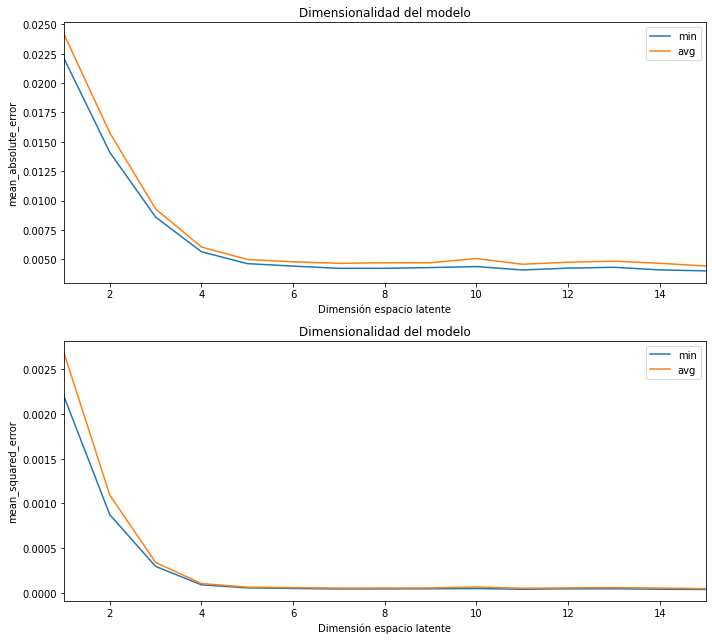

In [28]:
img_name= 'results/costo_SSA_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [29]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)